# GAUSSIAN PROCESS

## Load libraries

In [7]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

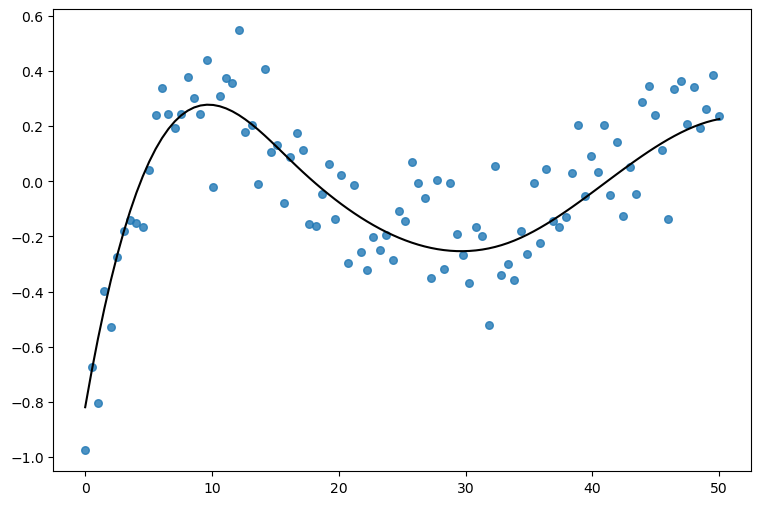

In [10]:
rng = np.random.default_rng(seed=121195)

size = 100
x = np.linspace(0, 50, size)
b = 0.1 * rng.normal(size=6)
sigma = 0.15

dm = design_matrices("0 + bs(x, df=6, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + rng.normal(size=size) * sigma
df = pd.DataFrame({"x": x, "y": y})

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [11]:
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2)", df)
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ InverseGamma(alpha: 3.0, beta: 2.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.2745)

In [12]:
idata = model.fit(inference_method="nuts_numpyro", random_seed=121195)
print(idata.sample_stats["diverging"].sum().to_numpy())

C:\Users\bacos1\anaconda3\envs\pymc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:25.496857
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/2000 [00:02<?, ?it/s]


Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]

Running chain 1:  40%|████      | 800/2000 [00:02<00:00, 7993.55it/s]


Running chain 0:  80%|████████  | 1600/2000 [00:02<00:00, 13853.39it/s][A

Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 923.92it/s] 


Sampling time =  0:00:02.449612
Transforming variables...
Transformation time =  0:00:00.257040
570


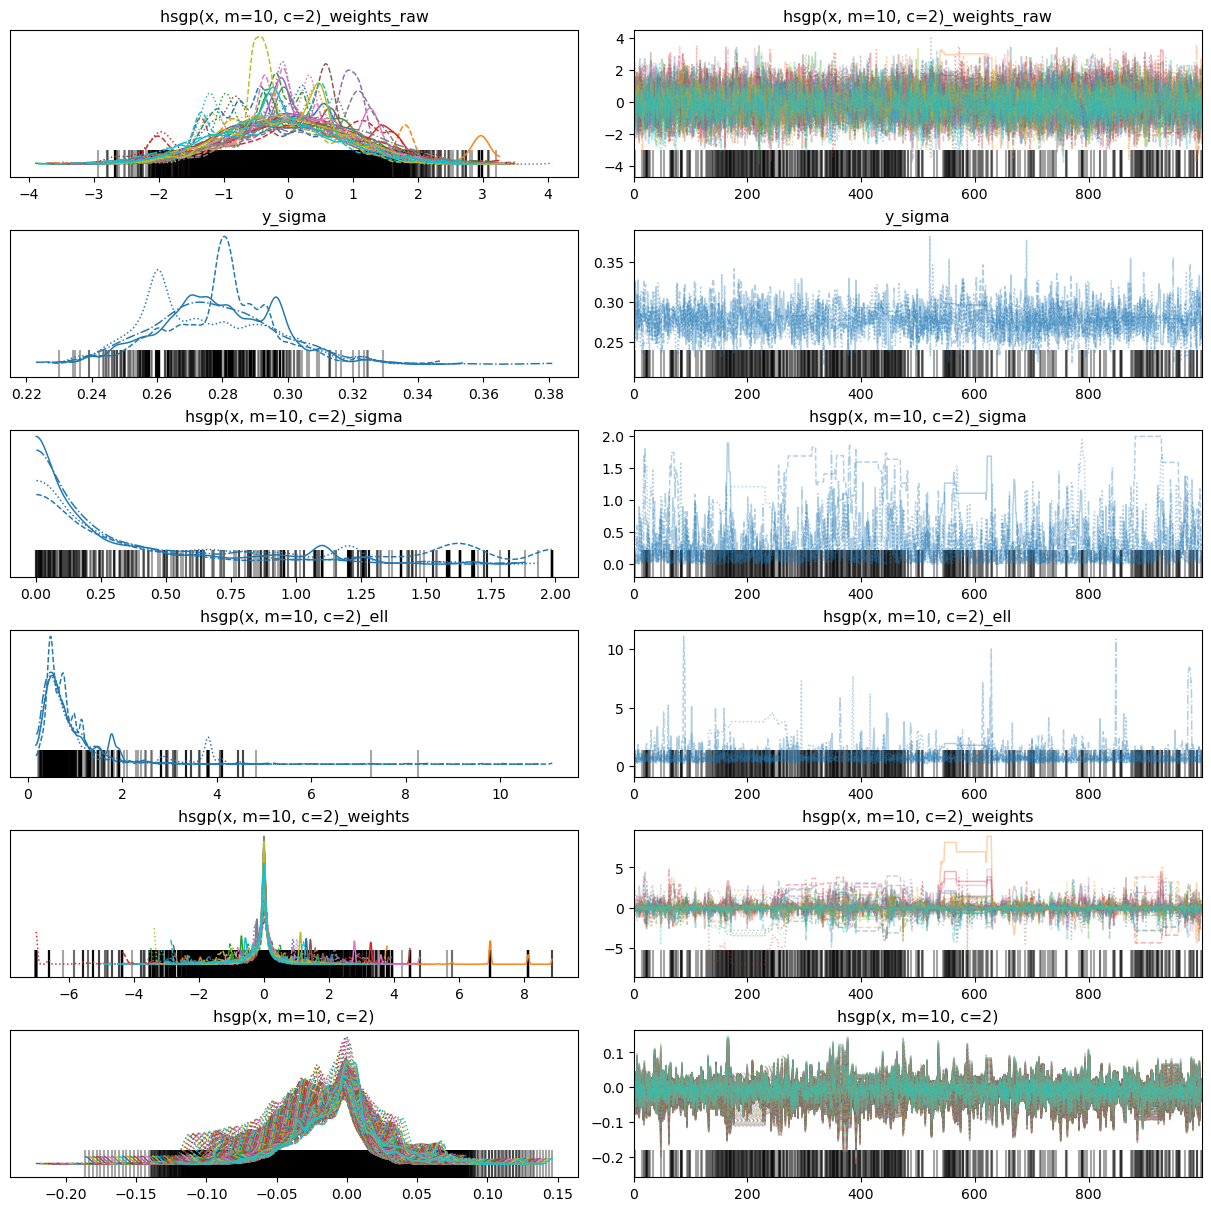

In [13]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

In [14]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2), # amplitude
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1) # lengthscale
}

In [15]:
priors = {
    "hsgp(x, m=10, c=2)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}

In [16]:
model = bmb.Model(
    "y ~ 0 + hsgp(x, m=10, c=2)", 
    df, 
    priors=priors
)
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2)
                cov: ExpQuad
                sigma ~ Exponential(lam: 2.0)
                ell ~ InverseGamma(mu: 10.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 10.0)

In [17]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9, random_seed=121195)
print(idata.sample_stats["diverging"].sum().to_numpy())

Compiling...
Compilation time =  0:00:03.479368
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/2000 [00:02<?, ?it/s]

Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]


Running chain 3:   0%|          | 0/2000 [00:02<?, ?it/s]


Running chain 1:  25%|██▌       | 500/2000 [00:02<00:00, 3957.41it/s]

Running chain 0:  55%|█████▌    | 1100/2000 [00:02<00:00, 5133.69it/s][A


Running chain 3:  50%|█████     | 1000/2000 [00:02<00:00, 4338.90it/s]

Running chain 1:  60%|██████    | 1200/2000 [00:02<00:00, 4728.95it/s]


Running chain 3:  75%|███████▌  | 1500/2000 [00:02<00:00, 4591.28it/s]

Running chain 1:  80%|████████  | 1600/2000 [00:02<00:00, 4036.81it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 733.26it/s] 


Sampling time =  0:00:02.890714
Transforming variables...
Transformation time =  0:00:00.250440
0


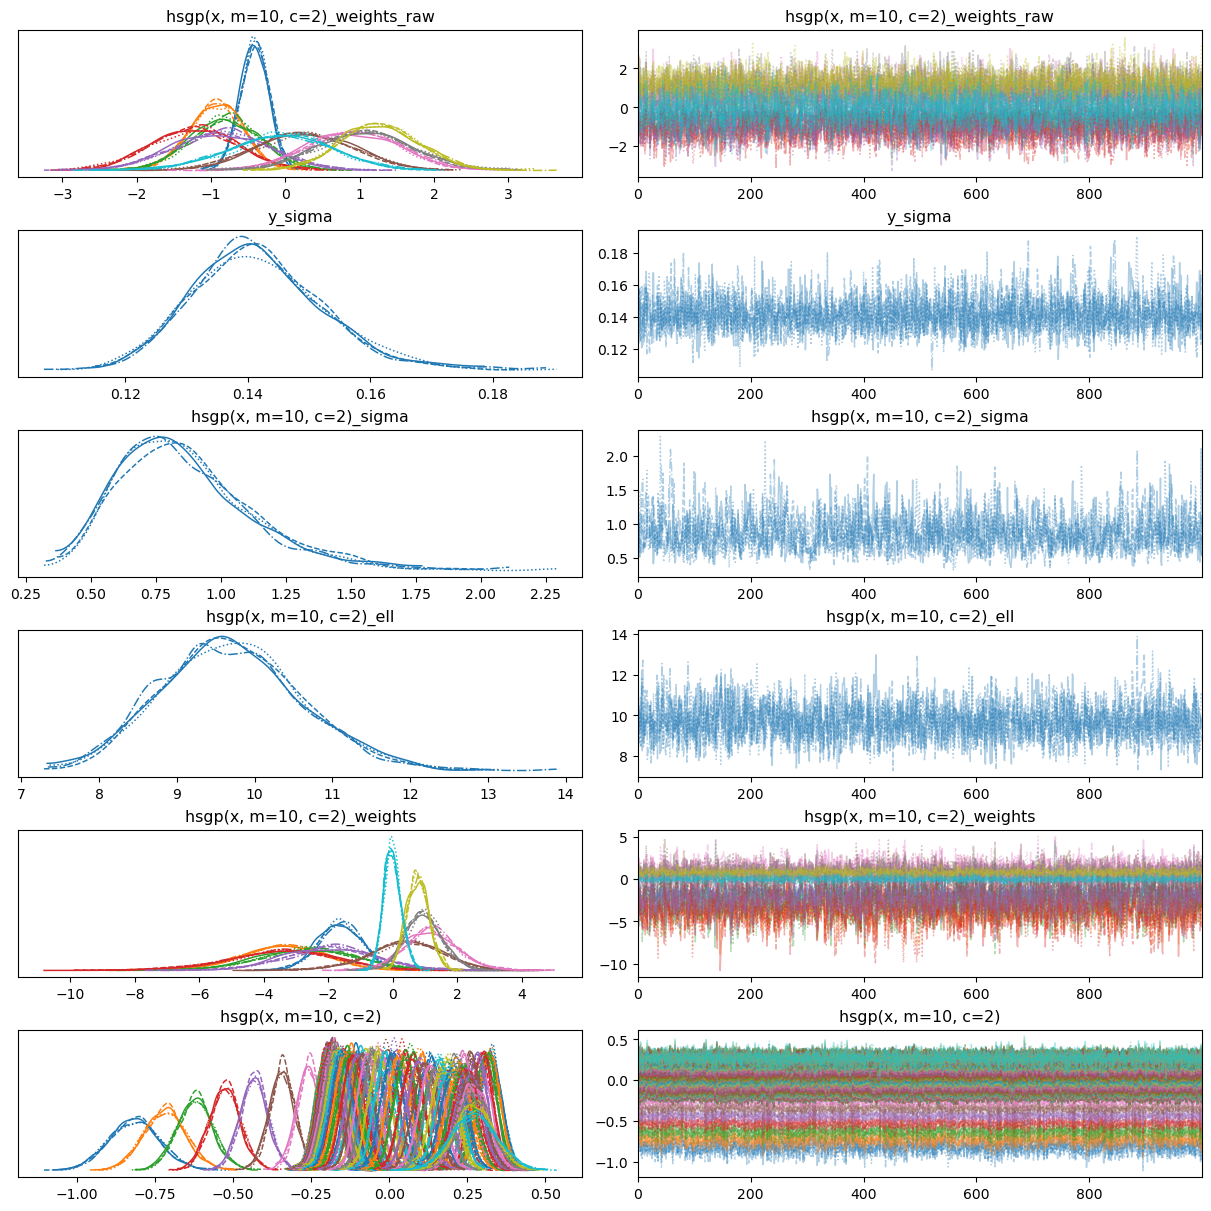

In [18]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

In [19]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2), # amplitude
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1) # lengthscale
}

# This is the dictionary we pass to Bambi
priors = {
    "hsgp(x, m=10, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2, centered=True)", df, priors=priors)
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2, centered=True)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2, centered=True)
                cov: ExpQuad
                sigma ~ Exponential(lam: 2.0)
                ell ~ InverseGamma(mu: 10.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 10.0)

In [20]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9, random_seed=121195)
print(idata.sample_stats["diverging"].sum().to_numpy())

Compiling...
Compilation time =  0:00:03.140993
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]


Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3:   0%|          | 0/2000 [00:01<?, ?it/s]

Running chain 1:  35%|███▌      | 700/2000 [00:02<00:00, 6996.04it/s]

Running chain 2:  30%|███       | 600/2000 [00:02<00:00, 5996.60it/s]


Running chain 1:  65%|██████▌   | 1300/2000 [00:02<00:00, 6353.54it/s]

Running chain 2:  60%|██████    | 1200/2000 [00:02<00:00, 5774.32it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:02<00:00, 6188.40it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 872.23it/s] 


Sampling time =  0:00:02.455159
Transforming variables...
Transformation time =  0:00:00.069681
0


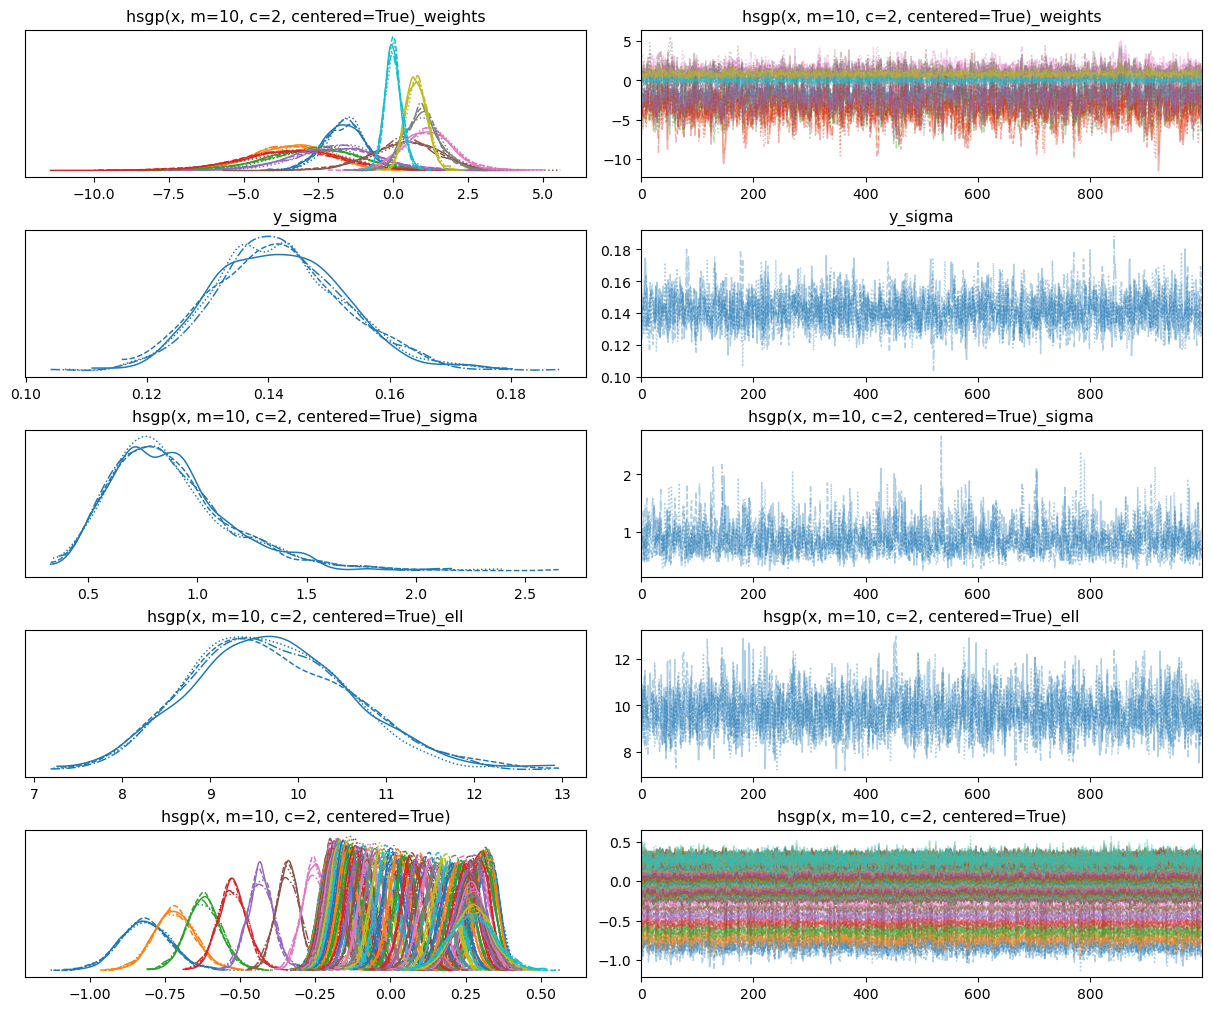

In [21]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});